# Starfysh tutorial on simulated ST dataset

**Azizi Lab**

Siyu He, Yinuo Jin

05-25-2023

This is a tutorial on a simple simulated ST [data](https://drive.google.com/drive/folders/1bLV37YzJle7Wq-q0HFIi6s8XG5sX9EVa?usp=share_link) (`simulated_ST_data_1`) generated from scRNA-seq data.

In this tutorial, we'll apply Starfysh's histology integration model to infer cell-type compositions in each spot by jointly embed expression & histology data.


In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip3 install scanpy
    #!pip3 install histomicstk
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    sys.path.append('/content/drive/MyDrive/SpatialModelProject/model_test_colab/')

In [2]:
import os
import numpy as np
import pandas as pd
import torch

In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import rcParams

font_list = []
fpaths = matplotlib.font_manager.findSystemFonts()
for i in fpaths:
    try:
        f = matplotlib.font_manager.get_font(i)
        font_list.append(f.family_name)
    except RuntimeError:
        pass

font_list = set(font_list)
plot_font = 'Helvetica' if 'Helvetica' in font_list else 'FreeSans'

rcParams['font.family'] = plot_font
rcParams.update({'font.size': 10})
rcParams.update({'figure.dpi': 300})
rcParams.update({'figure.figsize': (3,3)})
rcParams.update({'savefig.dpi': 500})

import warnings
warnings.filterwarnings('ignore')

## Load starfysh

In [4]:
from starfysh import (AA, utils, plot_utils, post_analysis)
from starfysh import starfysh as sf_model

### (1). load data and marker genes:

File Input: 
- Spatial transcriptomics 
    - Count matrix: `adata`
    - (Optional): Paired histology & spot coordinates: `img`, `map_info`
    
- Annotated signatures (marker genes) for potential cell types: `gene_sig`

Starfysh is built upon scanpy and Anndata. The common ST/Visium data sample folder consists a expression count file (usually `filtered_feature_bc_matrix.h5`), and a subdirectory with corresponding H&E image and spatial information, as provided by Visium platform.

For example, our example ST data + marker genes has the following structure (If you're running this tutorial locally, please download the simulation [data](https://drive.google.com/drive/folders/14Zcz3h_IX50kFmZnKQwBI5y9PeyGz949?usp=share_link) and [signature gene sets](https://drive.google.com/file/d/1SaNMDk5vL_q3GOFQPVwzmgvpZwRTbyNi/view?usp=share_link) and save them accordingly):
```
├── ../data
    tnbc_signature.csv

    ├── simulated_ST_data_1:
        \__ counts.st_synth.csv

        ├── (Optional) spatial:
            \__ aligned_fiducials.jpg
                detected_tissue_image.jpg
                scalefactors_json.json
                tissue_hires_image.png
                tissue_lowres_image.png
                tissue_positions_list.csv

```

For data that doesn't follow the common visium data structure (e.g. missing `filtered_featyur_bc_matrix.h5` or the given `.h5ad` count matrix file lacks spatial metadata), please construct the data as Anndata synthesizing information as the example simulated data shows:

In [5]:
# Loading expression counts and signature gene sets
data_path = '../data/'
sample_id = 'simulated_ST_data_1'
adata, adata_normed = utils.load_adata(data_folder=data_path,  # root data directory
                                       sample_id=sample_id,  # sample_id
                                       n_genes=2000  # number of highly variable genes to keep
                                      )


gene_sig = pd.read_csv(os.path.join('../data','tnbc_signature.csv'))
gene_sig = utils.filter_gene_sig(gene_sig,adata.to_df()) # filter out low-quality marker genes
gene_sig.head()

[2023-05-25 17:39:21] Preprocessing1: delete the mt and rp
[2023-05-25 17:39:23] Preprocessing2: Normalize
[2023-05-25 17:39:23] Preprocessing3: Logarithm
[2023-05-25 17:39:23] Preprocessing4: Find the variable genes


CAFs Cancer Epithelial Myeloid Normal Epithelial T-cells
0     DCN           SCGB2A2    C1QB             KRT14    CCL5
1  COL1A1              CD24     LYZ             KRT17    IL7R
2     LUM             MUCL1    C1QA               LTF    GNLY
3  COL1A2             KRT19    C1QC             KRT15    NKG7
4   SFRP2           SCGB1D2  TYROBP               PTN    CD3E

In [6]:
adata

AnnData object with n_obs × n_vars = 2500 × 20470
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'highly_variable'

Load paired spatial information:<br>
For simulation data, we set `has_histology` accordingly depending on the existence of synthetic H&E image

In [7]:
has_histology = True

if has_histology: # read both spatial coords & histology
    img_metadata = utils.preprocess_img(data_path,
                                        sample_id,
                                        adata_index=adata.obs.index,
                                        hchannel=False)

    img, map_info, scalefactor = img_metadata['img'], img_metadata['map_info'], img_metadata['scalefactor']
    map_info = map_info[['array_row', 'array_col']].astype(float)
    
else: # read only spatial coords
    map_info = pd.read_csv(os.path.join(data_path, sample_id, 'spot_list.csv'), index_col=[0])

    # Create dummy dict. as img_metadata
    img_metadata = {
        'img': None,
        'map_info': map_info,
        'scalefactor': None
    }

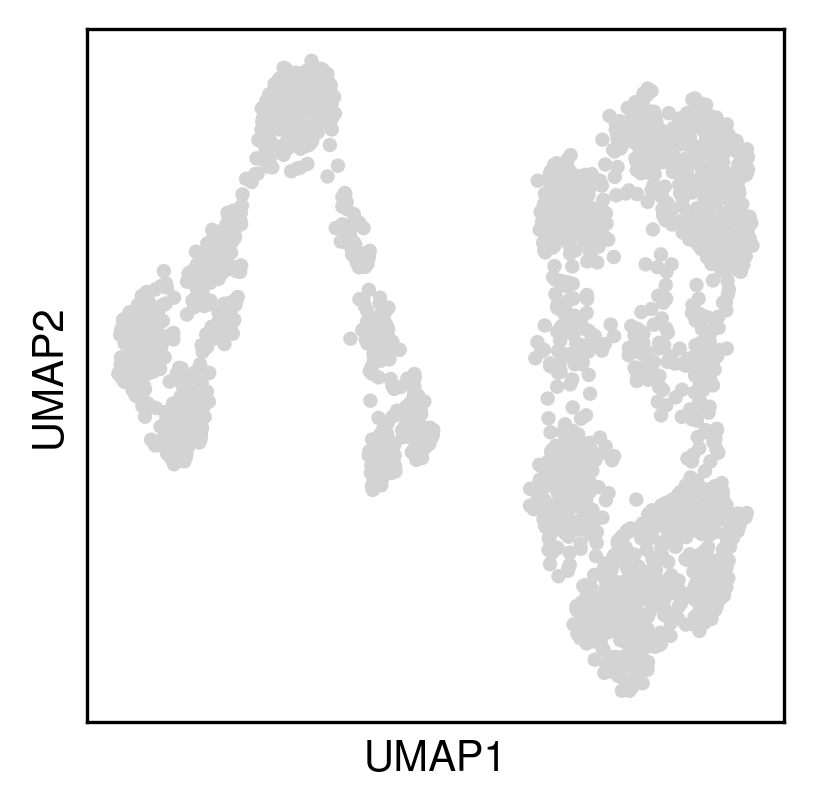

In [8]:
umap_df = utils.get_umap(adata_normed, display=True)

### (2). Preprocessing

Starfysh calcualates cell-type proportion scores for each spot given the annotated signatures (per cell type) as the model's prior

Each spot will be ranked (`anchors_df`) based on the prior, which represents the rough estimation of the given cell-type's enrichment

In [9]:
visium_args = utils.VisiumArguments(adata,
                                    adata_normed,
                                    gene_sig,
                                    img_metadata,
                                    window_size=1,
                                    sig_version='gene_score',
                                    sample_id=sample_id
                                   )

adata, adata_normed = visium_args.get_adata()
anchors_df = visium_args.get_anchors()

[2023-05-25 17:39:30] Subsetting highly variable & signature genes ...
[2023-05-25 17:39:36] Smoothing library size by taking averaging with neighbor spots...
[2023-05-25 17:39:37] Retrieving & normalizing signature gene expressions...
[2023-05-25 17:39:38] Identifying anchor spots (highly expression of specific cell-type signatures)...


- Visualize the spatial data

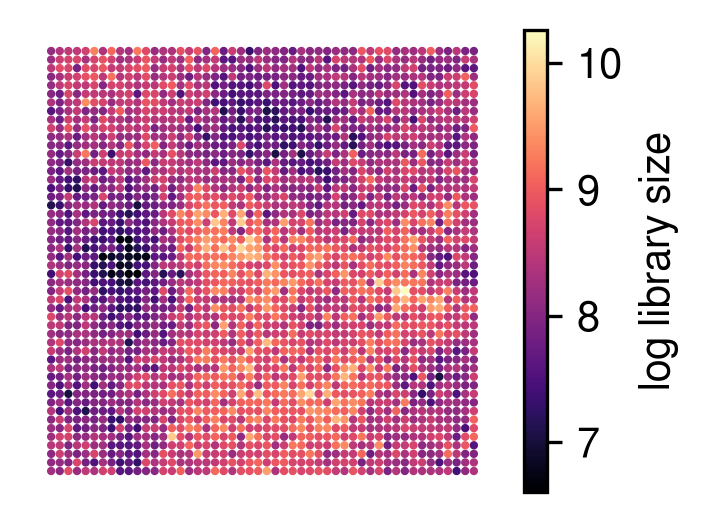

In [10]:
plot_utils.plot_spatial_feature(adata,
                                map_info,
                                visium_args.log_lib,
                                label='log library size',
                                )

raw gene expression:

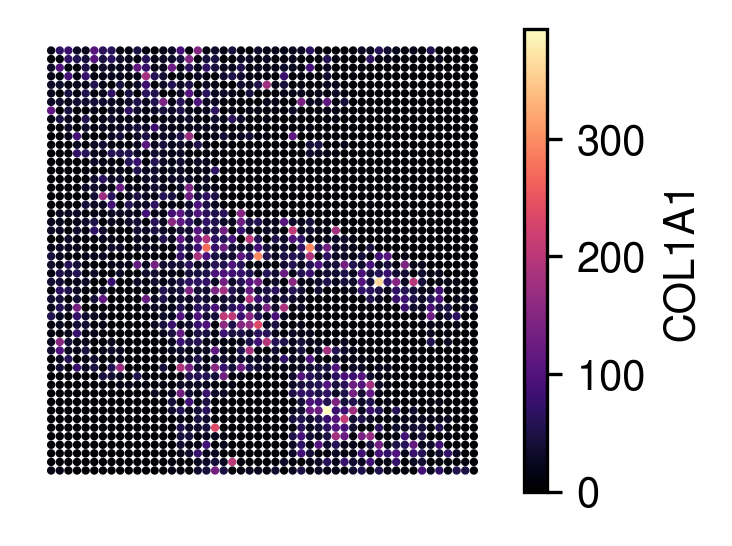

In [11]:
plot_utils.plot_spatial_gene(adata,
                             map_info,
                             gene_name='COL1A1'
                            )

### (3). Optional: Archetypal Analysis
Overview:
If users don't provide annotated gene signature sets with cell types, Starfysh identifies candidates for cell types via archetypal analysis (AA). The underlying assumption is that the geometric "extremes" are identified as the purest cell types, whereas all other spots are mixture of the "archetypes". If the users provide the gene signature sets, they can still optionally apply AA to refine marker genes and update anchor spots for known cell types. In addition, AA can identify & assign potential novel cell types / states. Here are the features provided by the optional archetypal analysis:
- Finding archetypal spots & assign 1-1 mapping to their closest anchor spot neighbors
- Finding archetypal marker genes & append them to marker genes of annotated cell types
- Assigning novel cell type / cell states as the most distant archetypes

Overall, Archetypal analysis is provided as a complementary toolkit for automatic cell-type annotation & signature gene completion:<br>

1. *If signature genes aren't provided:* <br><br>Archetypal analysis defines the geometric extrema of the data as major cell types with corresponding marker genes.<br><br>

2. *If full, completed signatures of all cell types are annotated*: <br><br>Users can skip this section and use only the signature priors<br><br>

3. *If signature genes are incomplete or require refinement*: <br><br>Archetypal analysis can be applied to
    a. Refine signatures of certain cell types
    b. Find novel cell types / states that haven't been provided from the input signature


#### If signature genes aren't provided


We will infer candidate cell types / states with Archetypal Analysis, and use the significantly enriched genes in each archetype as the signatures:


```Python
aa_model = AA.ArchetypalAnalysis(adata_orig=adata_normed)
archetype, arche_dict, major_idx, evs = aa_model.compute_archetypes(r=40)

# (1). Find archetypal spots & archetypal clusters
arche_df = aa_model.find_archetypal_spots(major=True)

# (2). Define "signature genes" as marker genes associated with each archetypal cluster
gene_sig = aa_model.find_markers(n_markers=30, display=False)
gene_sig.head()
```

#### If full signature genes are known

Users can skip this section & run Starfysh

#### If signature genes are provided with potential incomplete annotations

**In this tutorial, we show an example to update anchor ranks & signatures with archetypal analysis**:<br>

(**Note: please check that the input count matrix is raw-count**)

In [12]:
aa_model = AA.ArchetypalAnalysis(adata_orig=adata)

# set large resolution / convergence criteria to obtain major archetypes
archetype, arche_dict, major_idx, evs = aa_model.compute_archetypes(cn=30,
                                                                    r=100,  
                                                                    converge=1e-2,
                                                                    display=False)

# Find neighbor community for each archetype
arche_df = aa_model.find_archetypal_spots(major=True)
markers_df = aa_model.find_markers(n_markers=30, display=False)

# Map archetypes to closest anchors within `r` nearest neighbors
# Choose the top 30% anchors of each cell type for mapping
percent_anchor = 0.3
n_ancs = int(percent_anchor*adata.shape[0])

anchors_df = visium_args.get_anchors()
map_df, map_dict = aa_model.assign_archetypes(anchor_df=anchors_df[:n_ancs],r=n_ancs)


[2023-05-25 17:39:40] Computing intrinsic dimension to estimate k...


6 components are retained using conditional_number=30.00


[2023-05-25 17:39:41] Estimating lower bound of # archetype as 4...
[2023-05-25 17:40:20] Calculating UMAPs for counts + Archetypes...
[2023-05-25 17:40:28] 0.9122 variance explained by raw archetypes.
Merging raw archetypes within 100 NNs to get major archetypes
[2023-05-25 17:40:28] Finding 20 nearest neighbors for each archetype...
[2023-05-25 17:40:28] Finding 30 top marker genes for each archetype...


- Visualize archetypes

(<Figure size 1800x1200 with 1 Axes>, <AxesSubplot:>)

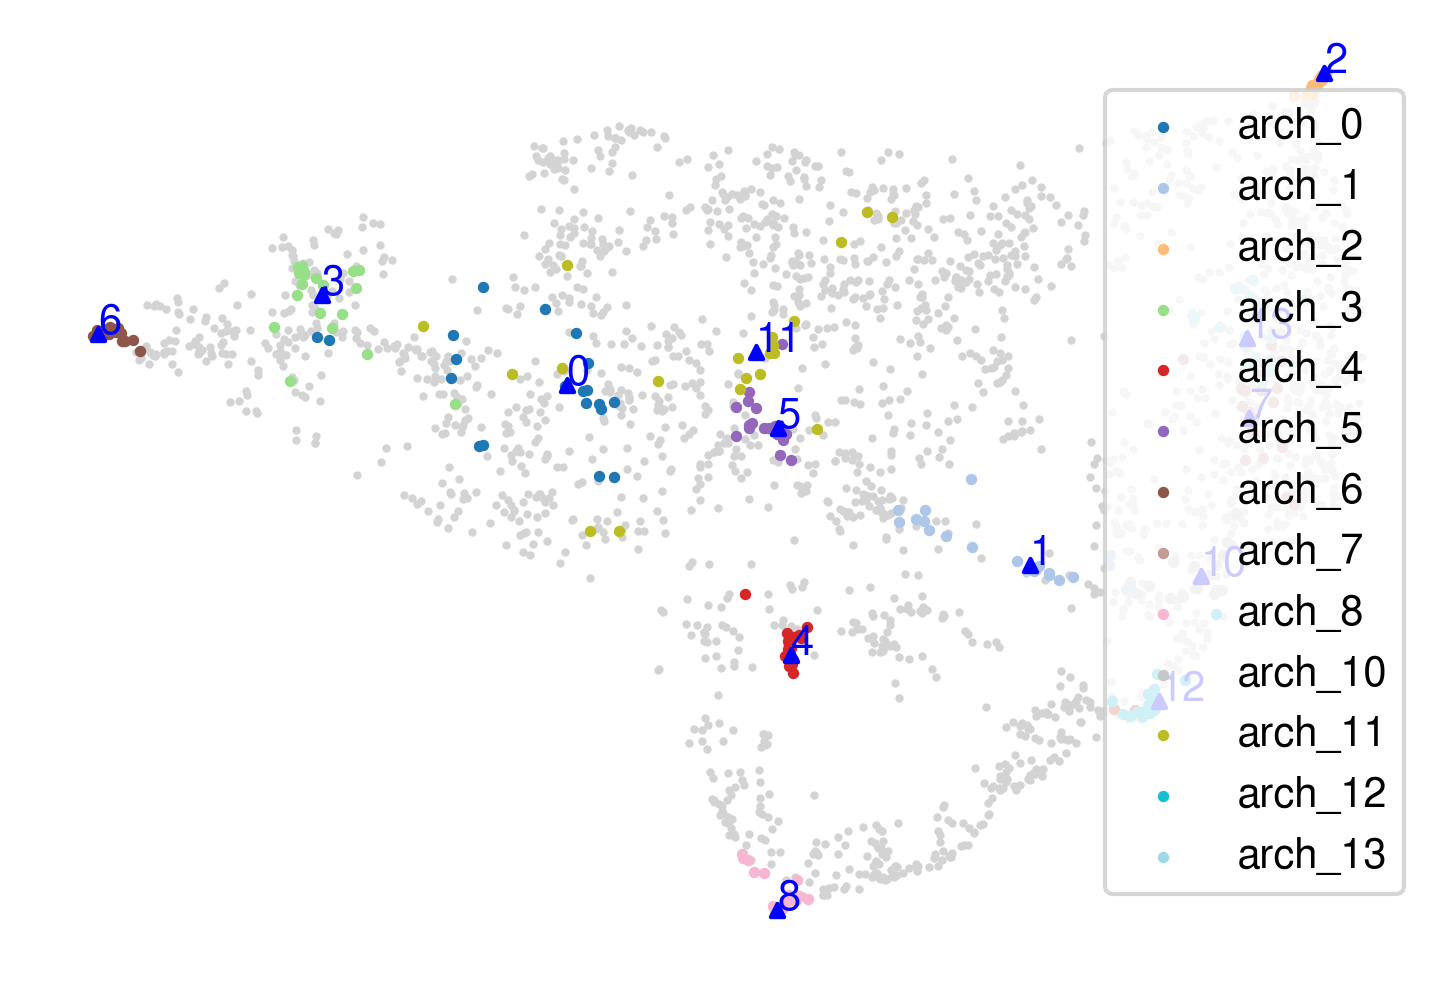

In [13]:
aa_model.plot_archetypes()

- Append archetypal markers to signatures based on best anchor-archetype mapping:<br><br>We used a thresholded stable matching to assign the best 1-1 maps between cell-type specific anchors to their closest archetypal community

In [14]:
gene_sig_arch = gene_sig.copy()

for cell_type in map_dict.keys():
    arch = map_dict[cell_type]
    gene_sig_arch = utils.append_sigs(gene_sig_arch, cell_type, markers_df[arch], n_genes=30)



Update anchor ranks based on the appended signatures:

In [15]:
visium_args = utils.VisiumArguments(adata,
                                    adata_normed,
                                    gene_sig_arch,
                                    img_metadata,
                                    window_size=1,
                                    sample_id=sample_id
                                   )

adata, adata_normed = visium_args.get_adata()
anchors_df = visium_args.get_anchors()

[2023-05-25 17:40:34] Subsetting highly variable & signature genes ...
[2023-05-25 17:40:40] Smoothing library size by taking averaging with neighbor spots...
[2023-05-25 17:40:42] Retrieving & normalizing signature gene expressions...
[2023-05-25 17:40:42] Identifying anchor spots (highly expression of specific cell-type signatures)...


##  Run starfysh

We perform `n_repeat` random restarts and select the best model with lowest loss for parameter `c` (inferred cell-type proportions):

### (1). Model parameters

In [16]:
n_repeats = 3
epochs = 150
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### (2). Model training

Our integrative model use paired histology to assist deconvolution predictions. All you need to do is to specify `poe=True` when running the model:

In [17]:
model_poe, loss = utils.run_starfysh(visium_args,
                                     n_repeats=n_repeats,
                                     epochs=epochs,
                                     
                                     # Enable histology integration
                                     poe=True,
                                     
                                     reg_nonanchors=True,
                                     test_prior=0.02*gene_sig_arch.shape[1],
                                     device=device)

[2023-05-25 17:40:44] Running Starfysh with 3 restarts, choose the model with best parameters...
[2023-05-25 17:40:44]  ===  Restart Starfysh 1 === 

[2023-05-25 17:40:47] Initializing model parameters...
[2023-05-25 17:41:11] Epoch[10/150], train_loss: 134562.9907, train_reconst: 1964.5734, train_u: 16.0692,train_z: 26.5374,train_c: 49.0307,train_n: 2.5109
[2023-05-25 17:41:34] Epoch[20/150], train_loss: 71603.5367, train_reconst: 1765.9418, train_u: 14.2012,train_z: 23.5833,train_c: 52.2321,train_n: 2.8533
[2023-05-25 17:41:57] Epoch[30/150], train_loss: 67305.7292, train_reconst: 1712.2007, train_u: 12.5351,train_z: 22.9121,train_c: 40.5236,train_n: 3.1001
[2023-05-25 17:42:20] Epoch[40/150], train_loss: 64866.2559, train_reconst: 1688.4887, train_u: 11.2373,train_z: 25.7062,train_c: 41.4075,train_n: 3.1775
[2023-05-25 17:42:43] Epoch[50/150], train_loss: 62901.2565, train_reconst: 1645.3092, train_u: 10.1928,train_z: 24.9432,train_c: 35.8204,train_n: 3.1931
[2023-05-25 17:43:10] Ep

### (3). Downstream analysis

#### Parse Starfysh inference output

In [18]:
inference_outputs, generative_outputs = sf_model.model_eval(model_poe,
                                                            adata,
                                                            visium_args,
                                                            poe=True,
                                                            device=device)

# Starfysh Deconvolution predictions
prop_pred_df = pd.DataFrame(adata.obsm['qc_m'], index=adata.obs_names, columns=gene_sig.columns)

####  Visualize starfysh deconvolution results


##### Assess deconvolution quality vs. Ground-truth


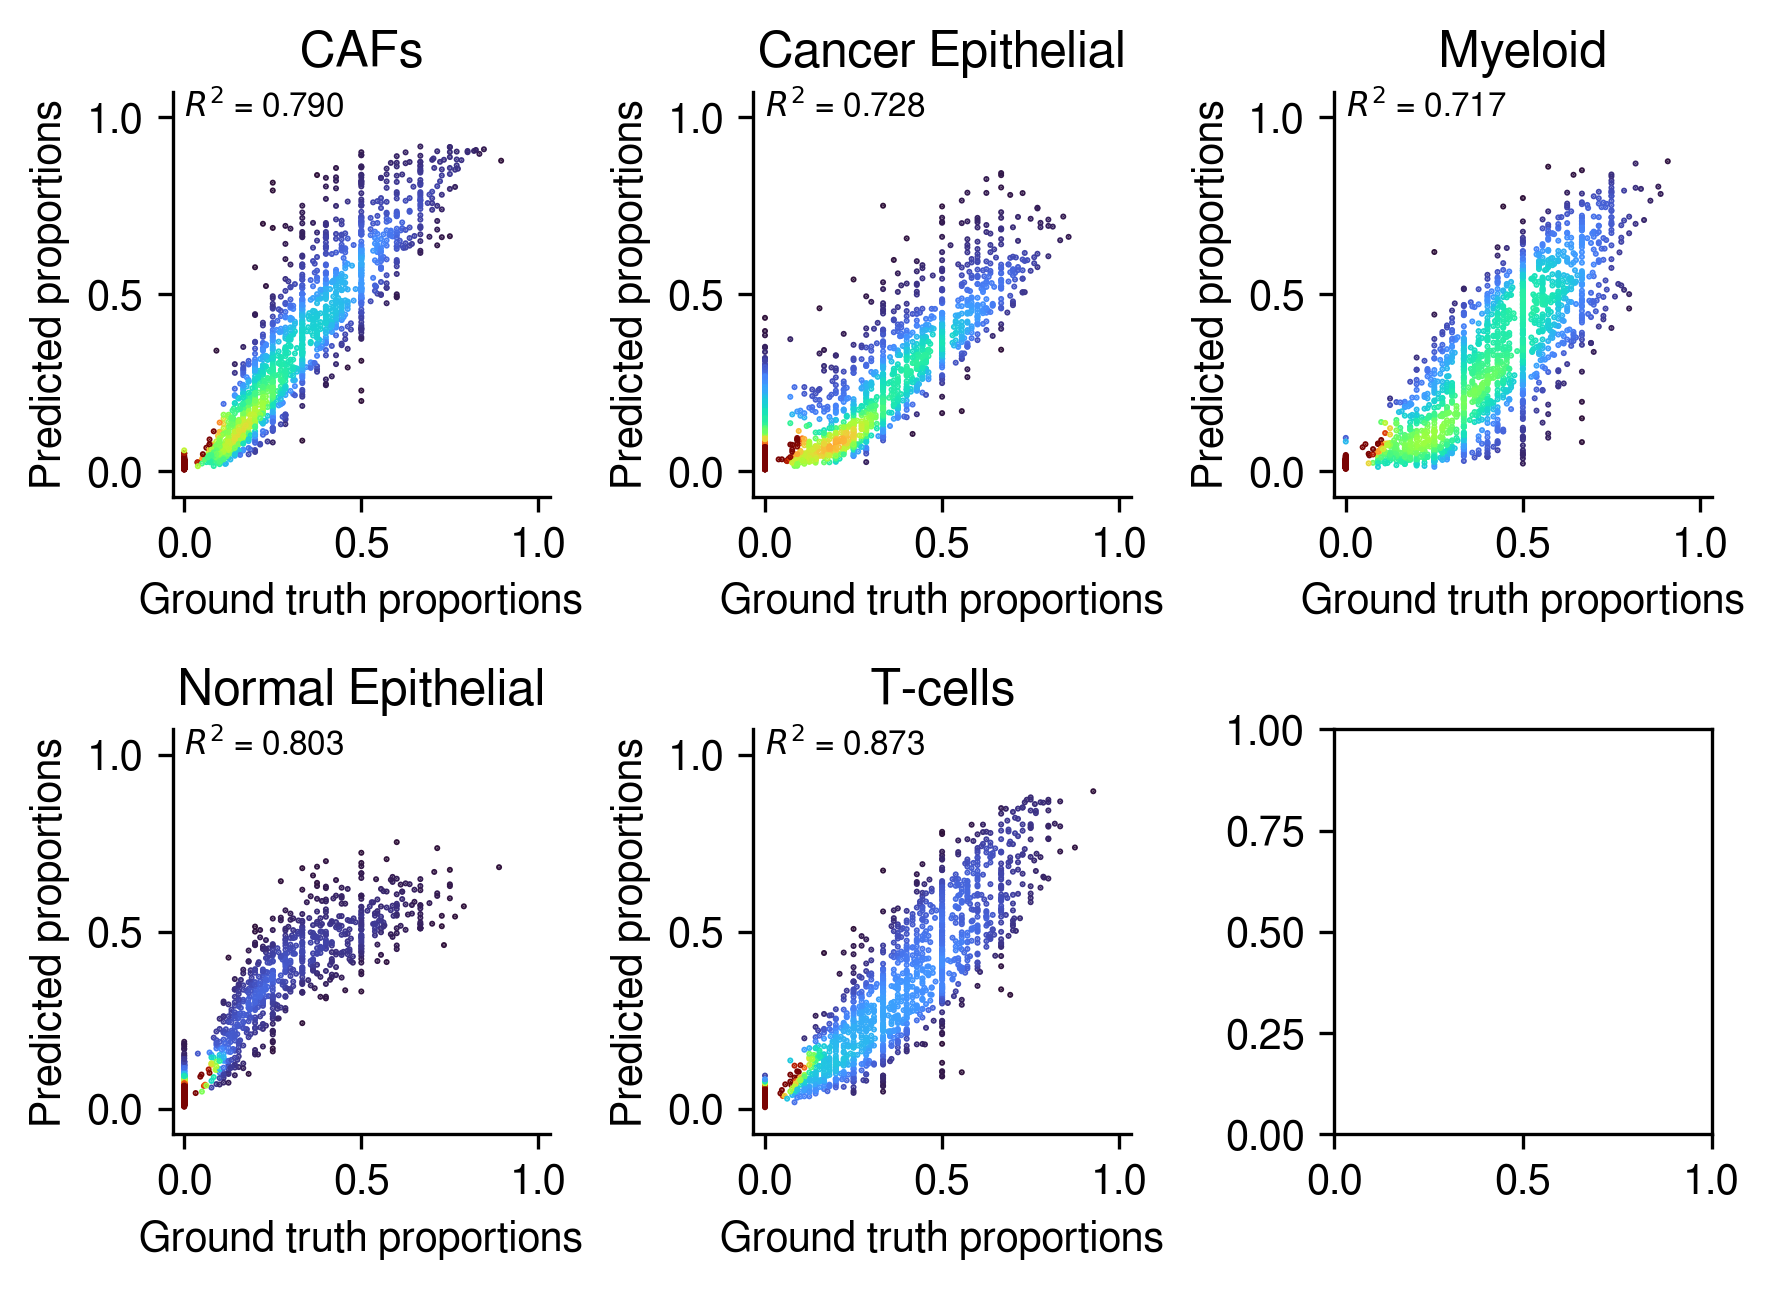

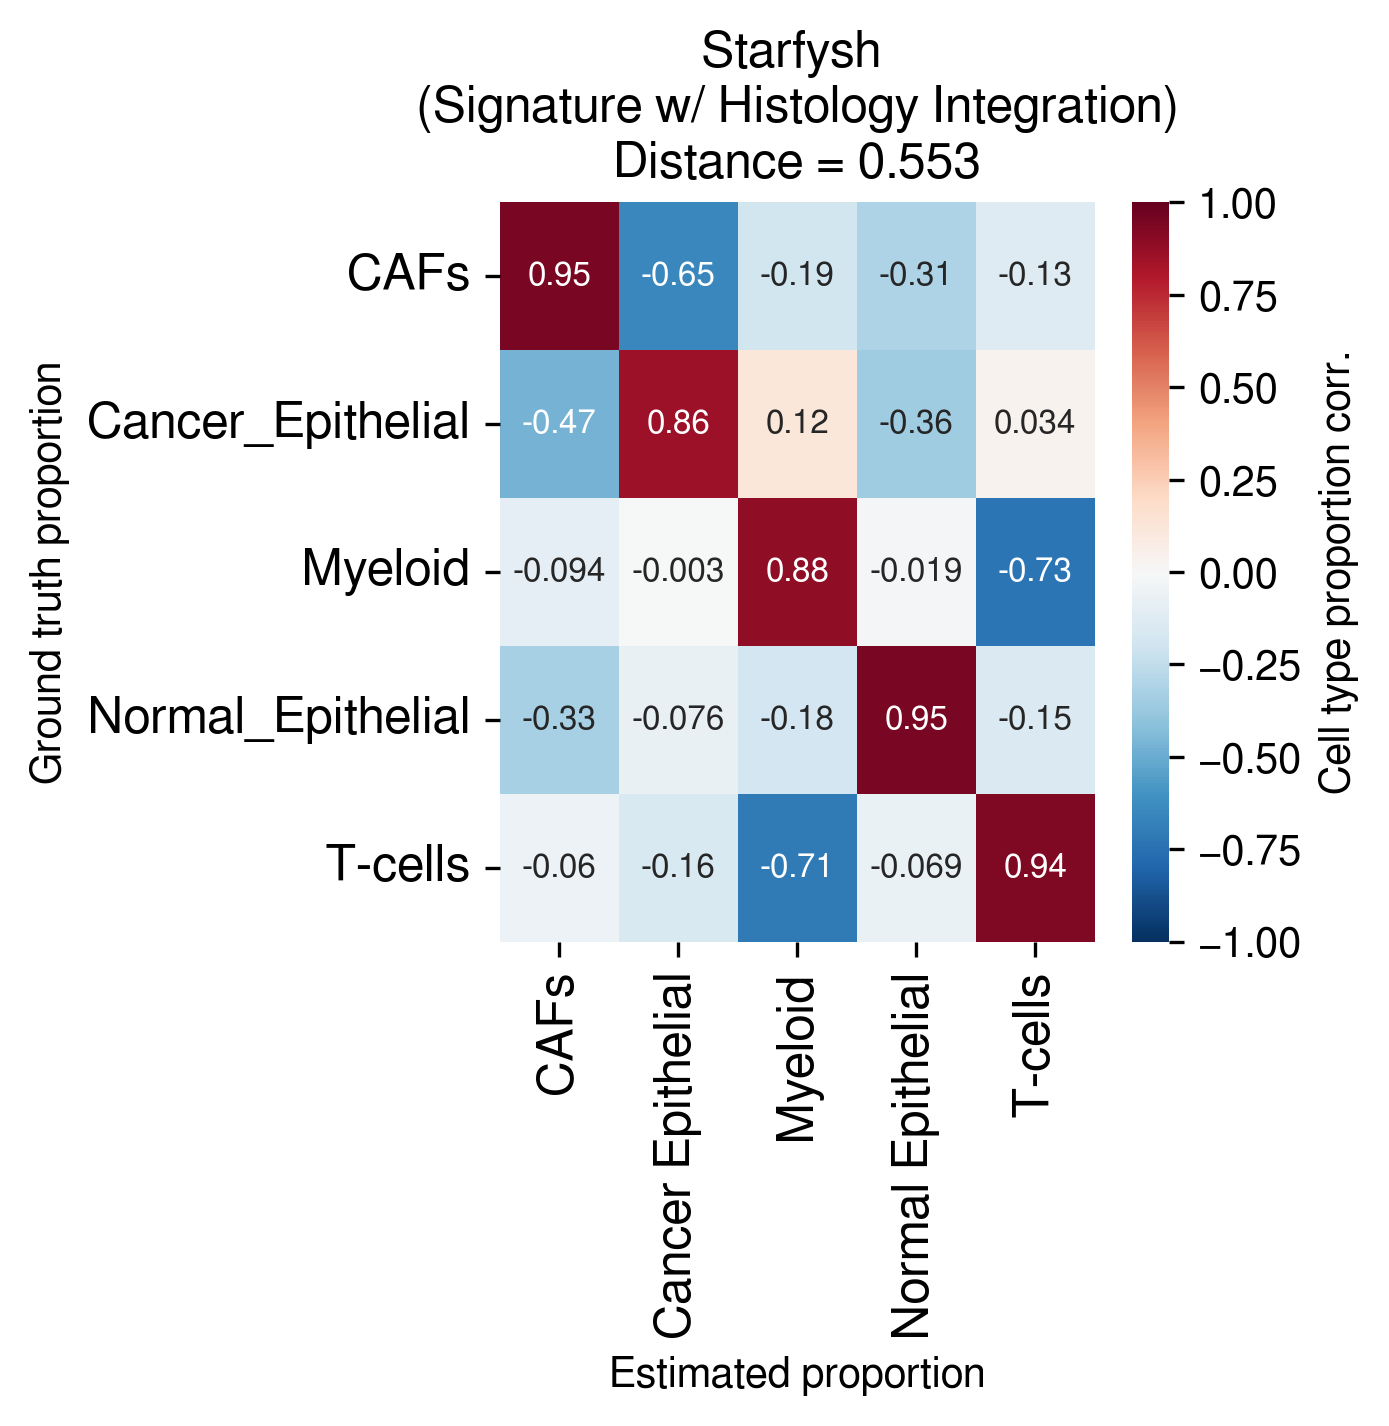

In [19]:
# Load ground-truth proportions in our simulation
mem_df = pd.read_csv(os.path.join(data_path, sample_id, 'members.st_synth.csv'),index_col=0)
prop_df = pd.read_csv(os.path.join(data_path, sample_id, 'proportions.st_synth.csv'),index_col=0)

plot_utils.disp_prop_scatter(prop_df, prop_pred_df)
plot_utils.disp_corr(
    prop_df,
    prop_pred_df,
    fontsize=8,
    title='Starfysh \n(Signature w/ Histology Integration)',
)

Visualize how good our inferred low-dimensional latent space `q(z)` represents the ground-truth compositions:

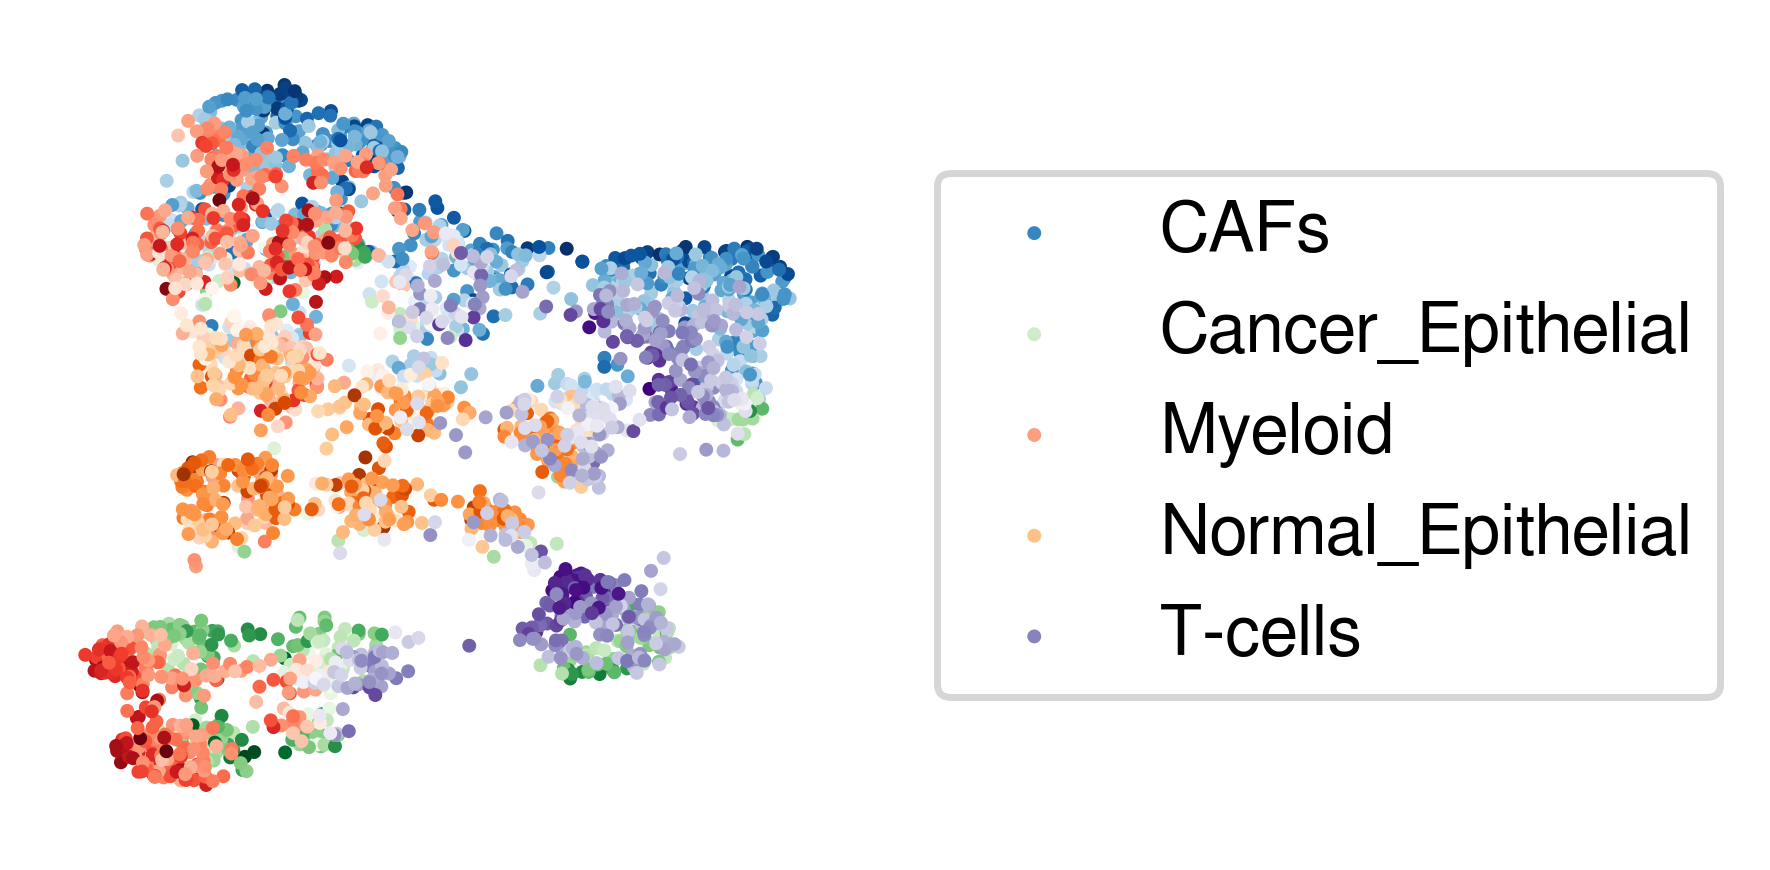

In [20]:
# Plot the ground-truth proportions on the inferred Z-space
qz_u = post_analysis.get_z_umap(adata.obsm['qz_m'])
post_analysis.plot_type_all(inference_outputs, qz_u, prop_df)

##### Spatial visualizations:

###### Infer density

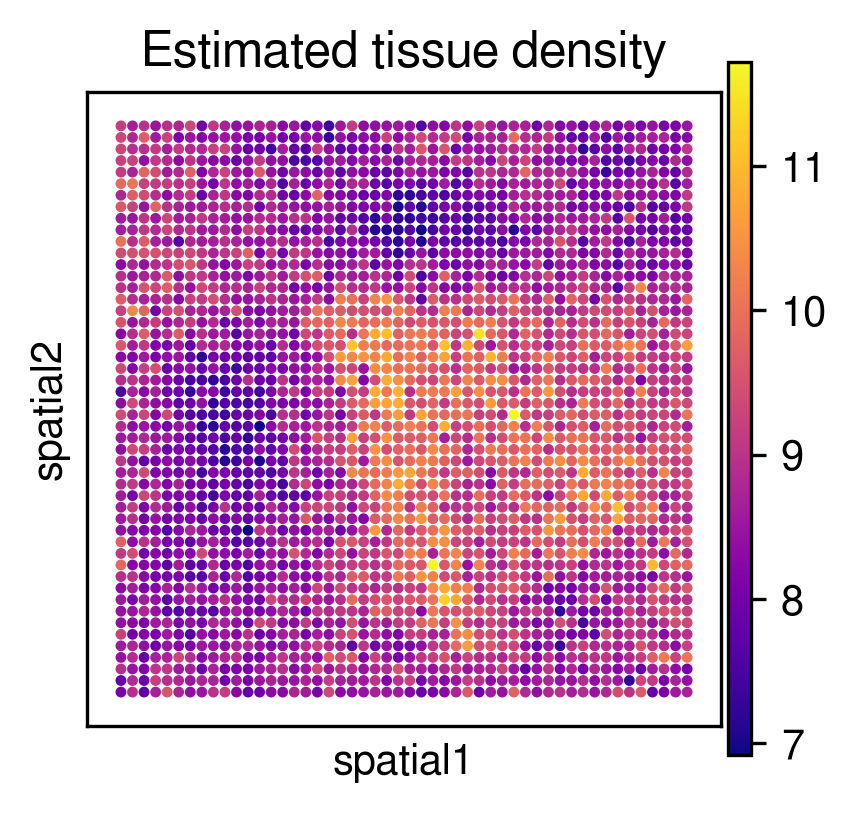

In [21]:
plot_utils.pl_spatial_inf_feature(adata,
                                  feature='ql_m',
                                  spot_size=30,
                                  vmin=None,
                                  cmap='plasma')

###### Infer proportions

**Visualization on UMAP of data**

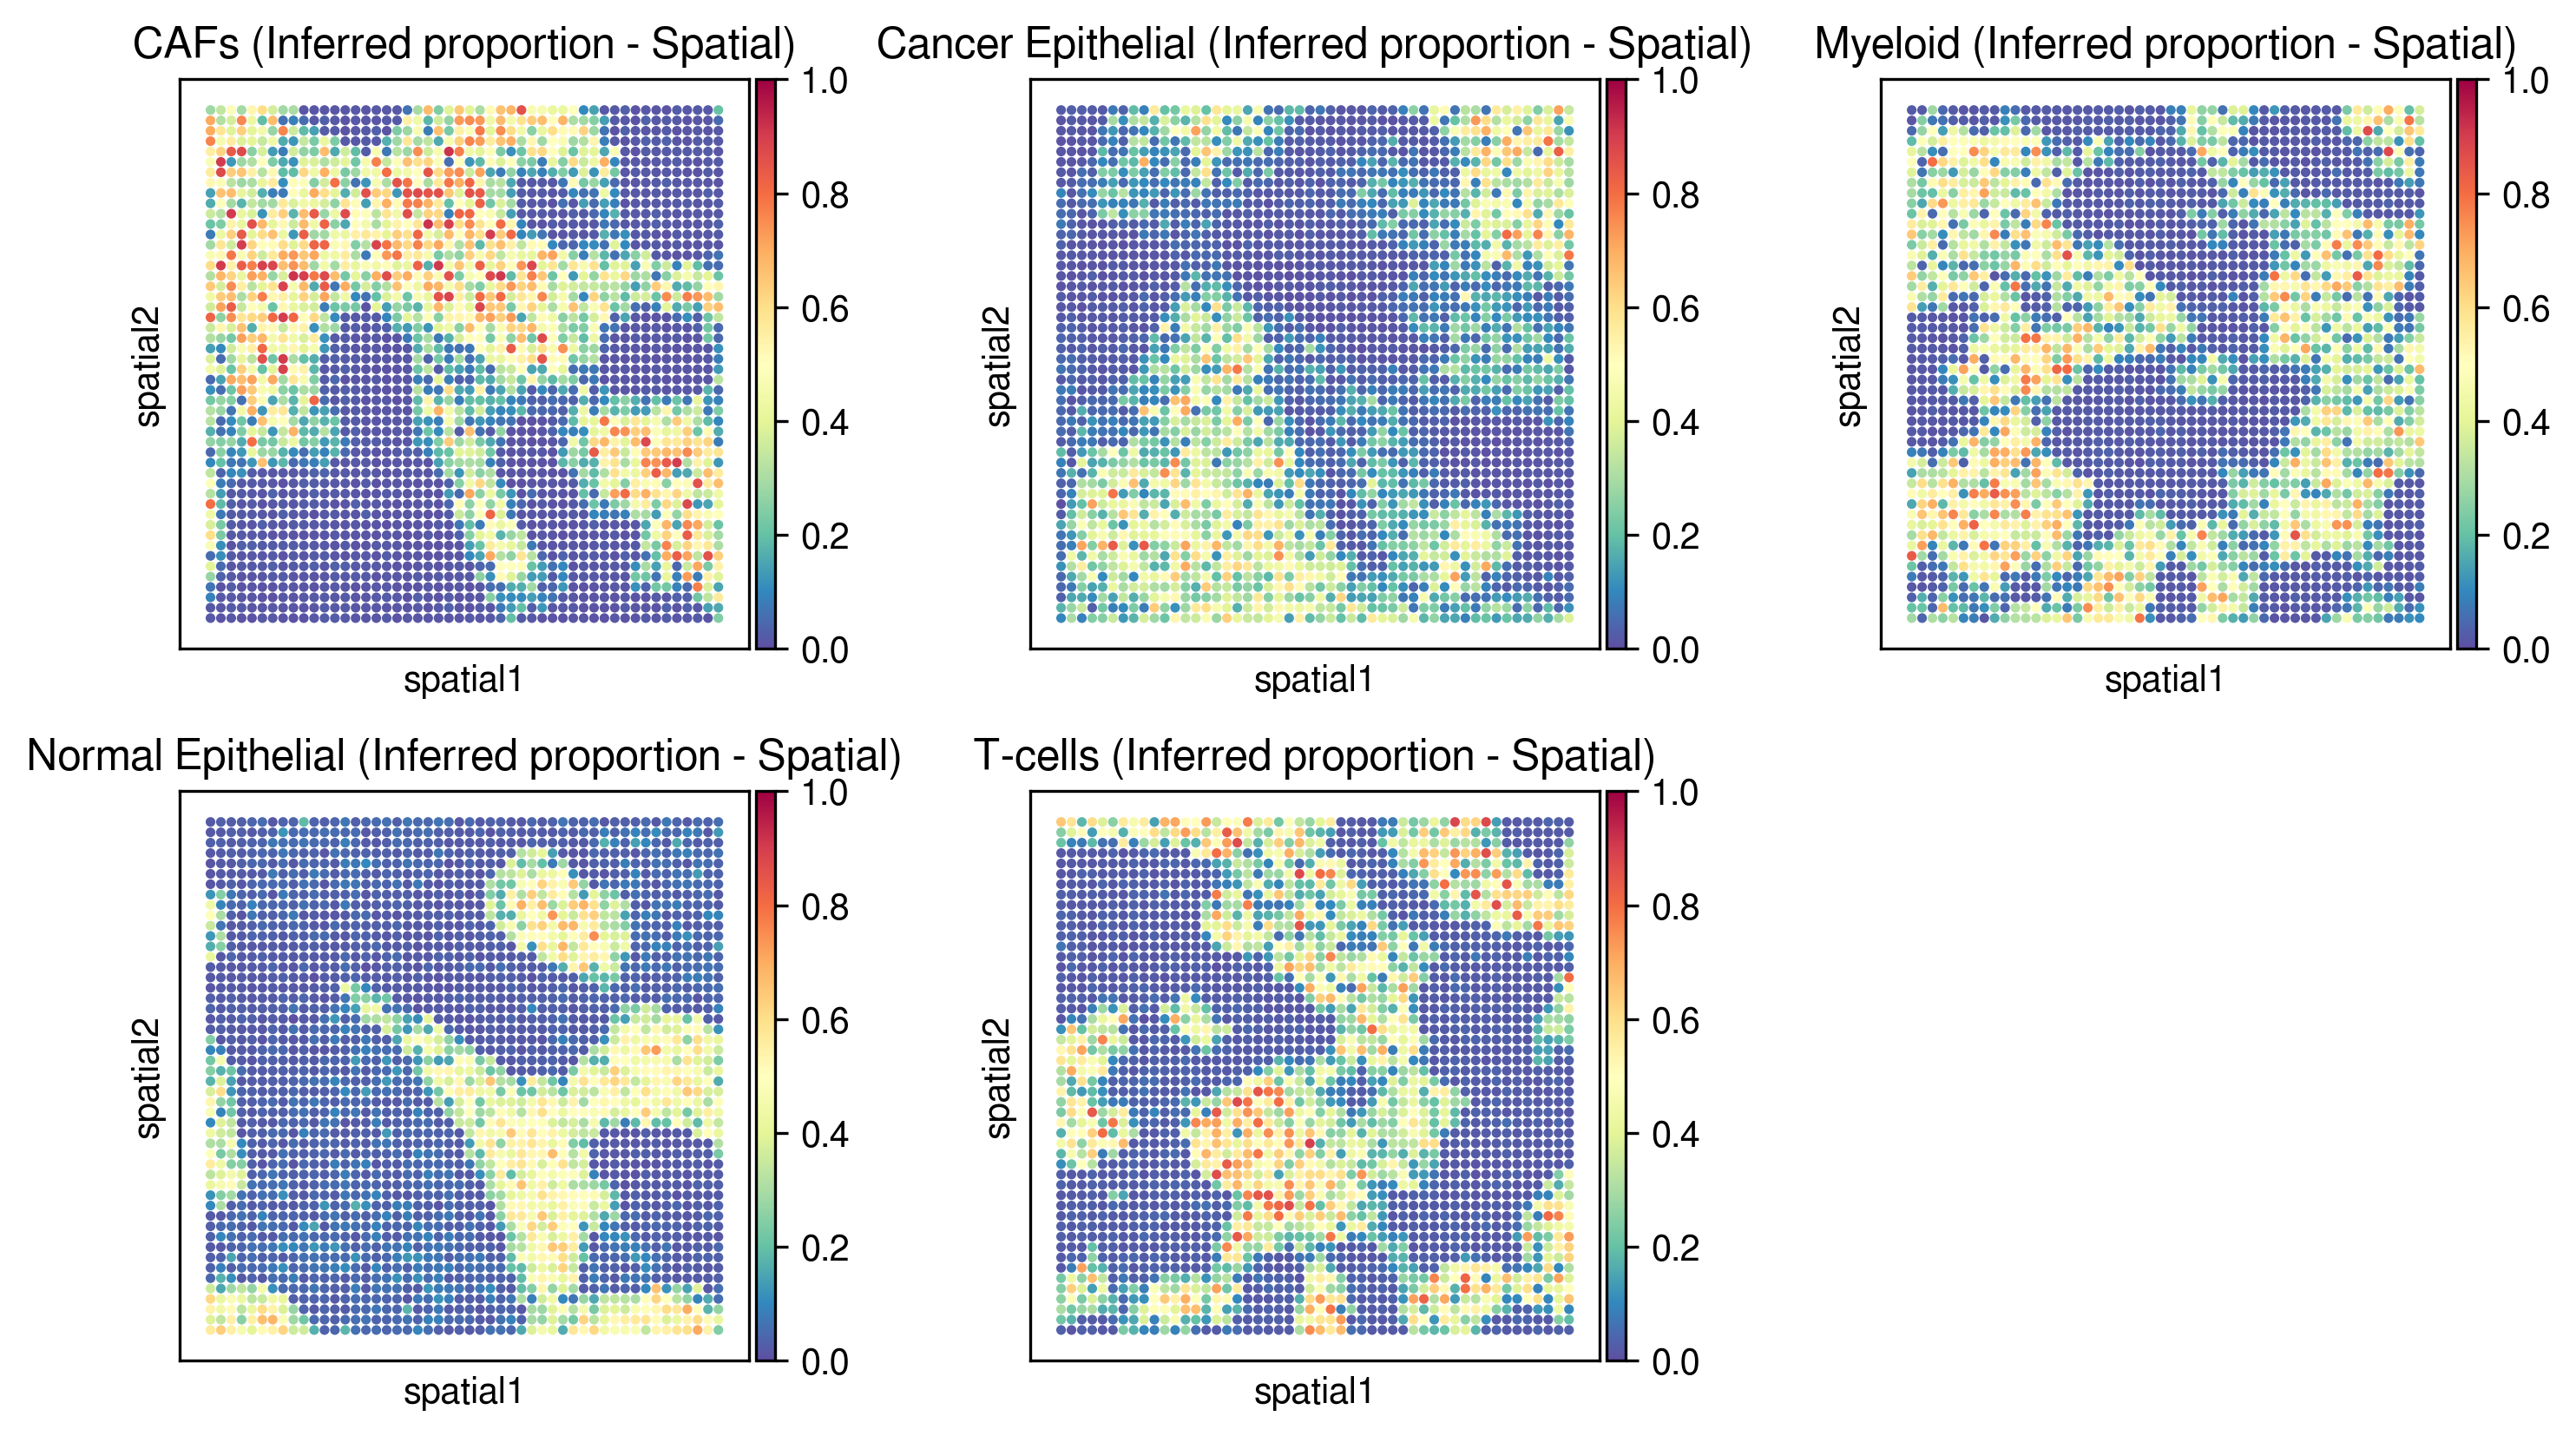

In [22]:
plot_utils.pl_spatial_inf_feature(adata,
                                  feature='qc_m',
                                  # To display for specific cell types:
                                  # factor = 'Cancer Epithelial', or factor = ['Cancer Epithelial, 'T-cells]
                                  spot_size=30,
                                  vmax=1)

**Visualization on UMAP of inferred `q(z)` space**

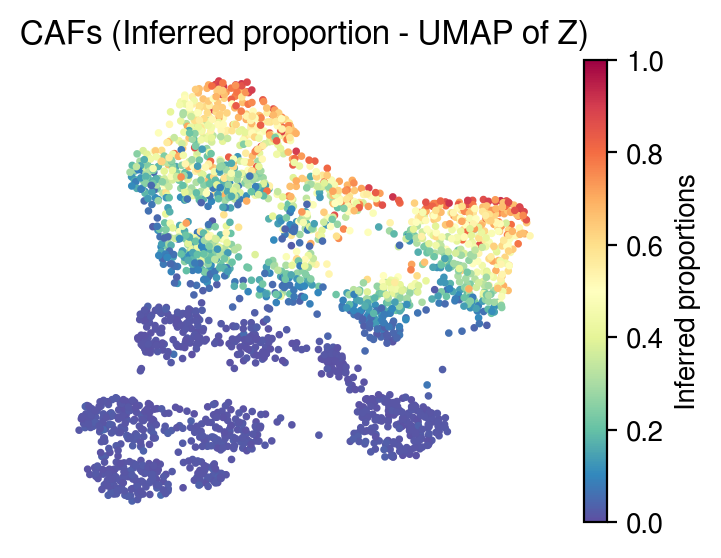

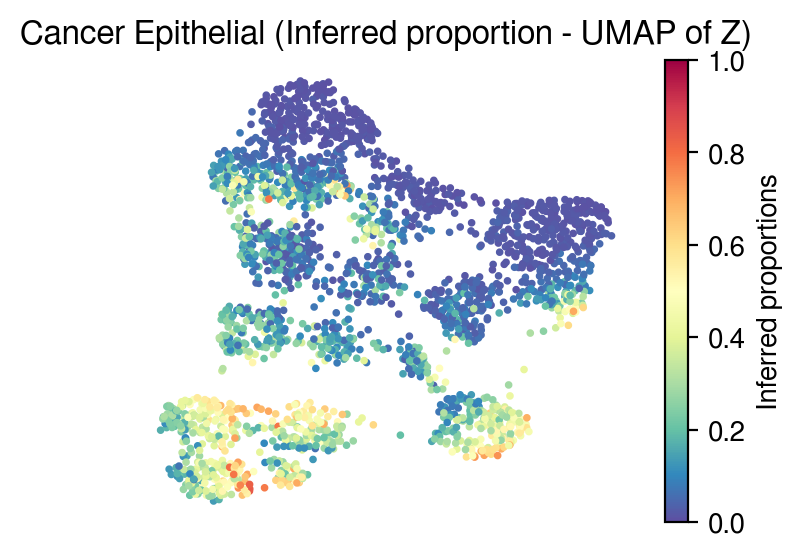

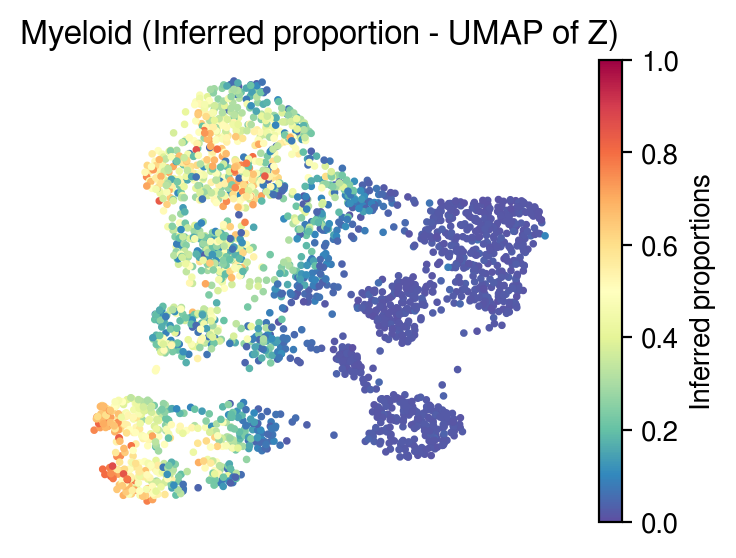

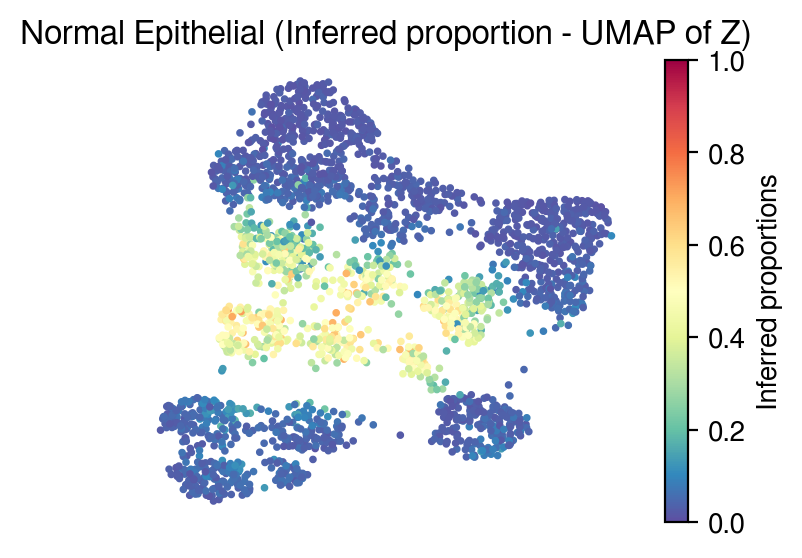

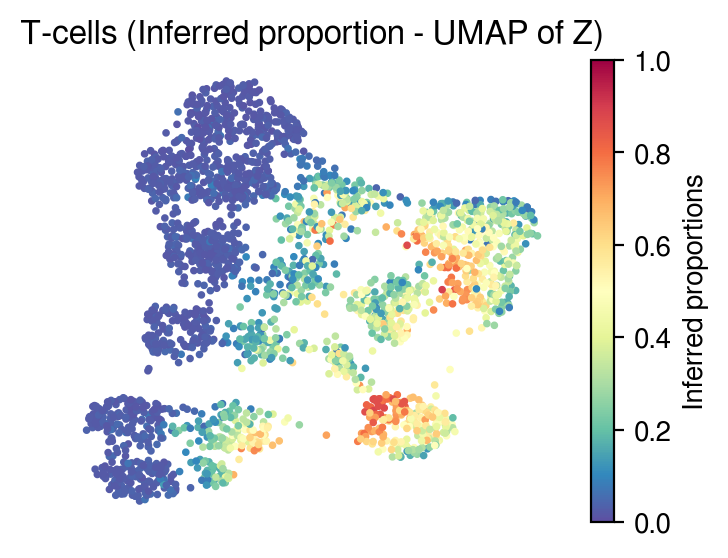

In [23]:
plot_utils.pl_spatial_inf_feature(adata,
                                  feature='qz_m',
                                  # To display for specific cell types:
                                  # factor = 'Cancer Epithelial', or factor = ['Cancer Epithelial, 'T-cells]
                                  spot_size=0.2,
                                  vmax=1)


##### Infer cell-type specific expressions for each spot

Given spot-level cell type deconvolution, Starfysh can further predict cell-type specific gene expressions for each spot:

In [24]:
pred_exprs = sf_model.model_ct_exp(model_poe,
                                   adata,
                                   visium_args,
                                   poe=True,
                                   device=device)


The inferred predictions for each cell type is a `S x G'` matrix:

E.g. Plot spot-level expression of `CD69` from *T-cells*:

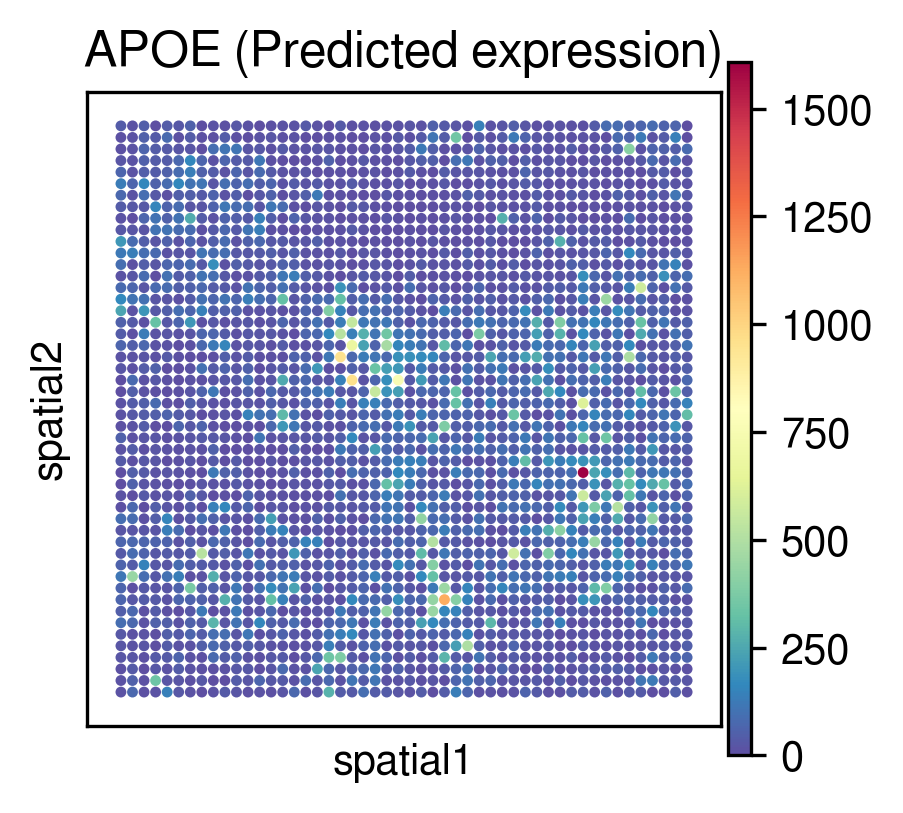

In [26]:
plot_utils.pl_spatial_inf_gene(adata,
                               factor='Myeloid',
                               feature='APOE',
                               spot_size=30)


## Save model & inferred parameters

In [27]:
# Specify output directory
outdir = './results/'
if not os.path.exists(outdir):
    os.mkdir(outdir)

# save the model
torch.save(model.state_dict(), os.path.join(outdir, 'starfysh_model.pt'))

# save `adata` object with inferred parameters
adata.write(os.path.join(outdir, 'st.h5ad'))

---